# Problema de transporte
## Problema desbalanceado

Supongamos el siguiente problema de transporte:

Se tienen tres plantas (P1, P2 y P3) cada una con capacidad de producción y despacho de 1000 unidades por semana. Hay tres clientes (C1, C2 y C3) con demandas de 1000, 1000 y 1200 unidades por semana respectivamente.

Los costos unitarios de transporte se muestran en la siguiente tabla:

|    | C1  | C2   | C3  |
| -- | --- | ---- | --- |
| P1 | 150 | 200  | 350 |
| P2 | 560 | 1200 | 85  |
| P3 | 690 | 300  | 178 |

Se debe determinar qué cantidad enviar desde cada planta hacia cada cliente de tal forma que se minimice el costo de transporte.

Ya que la capacidad semanal de producción de las plantas es menor que la demanda de los clientes (por 200 unidades), es necesario crear un origen ficticio cuya capacidad son esas 200 unidades. Lo que el problema determine que se "envía" desde esta planta, será demanda no satisfecha.

### Formulación del problema

#### Conjuntos:

Plantas (orígenes): $i=\left \{ 1,2,3,4 \right \}$.

Clientes (destinos): $j=\left \{ 1,2,3 \right \}$.


In [1]:
# Importar librerías
from ortools.linear_solver import pywraplp
import pandas as pd

# Conjuntos
plantas = ['P1', 'P2', 'P3', 'PF']
clientes = ['C1', 'C2', 'C3']

# Número de plantas y clientes
num_plantas = len(plantas)
num_clientes = len(clientes)

#### Parámetros

Costos unitarios de transporte:

$$C_{i,j}=\begin{bmatrix}
150 & 200 & 350\\ 
560 & 1200 & 85\\ 
690 & 300 & 178\\ 
0 & 0 & 0
\end{bmatrix}$$

In [2]:
# Utlizamos diccionario
costo = {
    ('P1', 'C1'): 150,
    ('P1', 'C2'): 200,
    ('P1', 'C3'): 350,
    ('P2', 'C1'): 560,
    ('P2', 'C2'): 1200,
    ('P2', 'C3'): 85,
    ('P3', 'C1'): 690,
    ('P3', 'C2'): 300,
    ('P3', 'C3'): 178,
    ('PF', 'C1'): 0,
    ('PF', 'C2'): 0,
    ('PF', 'C3'): 0
    }

Capacidad de las plantas:
$$S_i=\begin{bmatrix}
1000\\
1000\\ 
1000\\ 
200
\end{bmatrix}$$

In [3]:
capacidad = {
    'P1': 1000,
    'P2': 1000,
    'P3': 1000,
    'PF': 200
    }

Demanda de los clientes:
$$D_j=\begin{bmatrix}
1000\\ 
1000\\ 
1200
\end{bmatrix}$$

In [4]:
demanda = {
    'C1': 1000,
    'C2': 1000,
    'C3': 1200
    }

#### Variables de decisión
$X_{i,j}$: cantidad a transportar (und/semana) entre la planta $i$ y el cliente $j$.

$X_{i,j} \geq 0, \forall i,j$

In [5]:
# Instanciar el modelo
solver = pywraplp.Solver('Transporte2', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

# Instanciar el infinito
inf = solver.infinity()

# Variables de decisión
X = {}  #Diccionario vacío

for planta in plantas:
    for cliente in clientes:
        X[planta,cliente] = solver.NumVar(0.0, inf, 'X[%s,%s]' % (planta, cliente))

#### Función objetivo

Minimizar los costos totales de transporte:

$$\text{Minimizar } Z =\displaystyle \sum_i\sum_j C_{i,j}X_{i,j}$$

In [6]:
# Función objetivo
solver.Minimize(solver.Sum([X[planta,cliente]*costo[(planta,cliente)] 
                            for planta in plantas 
                            for cliente in clientes]))

#### Restricciones

No se puede superar la capacidad de las plantas:

$$\displaystyle \sum_j X_{i,j} \leq S_i, \forall i$$

In [7]:
# Capacidad de las plantas
rest_cap = [] #Lista con los nombres de las restricciones
for planta in plantas:
    solver.Add(solver.Sum([X[planta,cliente] for cliente in clientes]) <= capacidad[planta], name = 'capacidad_%s' % planta)
    rest_cap.append('capacidad_%s' % planta)

Se debe satisfacer la demanda de los clientes:
$$\displaystyle \sum_i X_{i,j} \geq D_j, \forall j$$

In [8]:
# Demanda de los clientes
rest_dem = [] #Lista con los nombres de las restricciones
for cliente in clientes:
    solver.Add(solver.Sum([X[planta,cliente] for planta in plantas]) >= demanda[cliente], name = 'demanda_%s' % cliente)
    rest_dem.append('demanda_%s' % cliente)

### Solucionar el modelo y mostrar los resultados

In [9]:
# Resolver el modelo
sol = solver.Solve()

# Imprimir resultados
print('Número de variables =', solver.NumVariables())
print('Número de restricciones =', solver.NumConstraints())
print('Costo = ', solver.Objective().Value())
print('Tiempo = ', solver.WallTime(), 'milisegundos')

Número de variables = 12
Número de restricciones = 7
Costo =  510600.0
Tiempo =  760894 milisegundos


In [10]:
# Variables de decisión
cols1 = ['Variable', 'Valor', 'Status', 'Costo_Reducido']
data1 = []
for planta in plantas:
    for cliente in clientes:
        data1.append([X[planta,cliente].name(), X[planta,cliente].solution_value(),
                      X[planta,cliente].basis_status(), X[planta,cliente].reduced_cost(),
                      ])

# Convertir en dataframe de pandas
sal1 = pd.DataFrame(data1, columns = cols1)

In [11]:
sal1

,Variable,Valor,Status,Costo_Reducido
0,"X[P1,C1]",1000.0,4,0.000000e+00
1,"X[P1,C2]",0.0,4,0.000000e+00
2,"X[P1,C3]",0.0,1,2.720000e+02
3,"X[P2,C1]",0.0,1,4.030000e+02
4,"X[P2,C2]",0.0,1,9.930000e+02
5,"X[P2,C3]",1000.0,4,1.421085e-14
6,"X[P3,C1]",0.0,1,4.400000e+02
7,"X[P3,C2]",800.0,4,0.000000e+00
8,"X[P3,C3]",200.0,4,0.000000e+00
9,"X[PF,C1]",0.0,1,5.000000e+01


In [12]:
# Restricciones
cols2 = ['Restricción','Status','Valor_Dual']
restricciones = rest_cap + rest_dem
data2 = []
for restriccion in restricciones:
    data2.append([solver.Constraint(restriccion).name(),
                  solver.Constraint(restriccion).basis_status(),
                  solver.Constraint(restriccion).dual_value()])

# Convertir en dataframe de pandas
sal2 = pd.DataFrame(data2, columns = cols2)

In [13]:
sal2

,Restricción,Status,Valor_Dual
0,capacidad_P1,0,0.0
1,capacidad_P2,0,0.0
2,capacidad_P3,0,0.0
3,capacidad_PF,0,0.0
4,demanda_C1,0,0.0
5,demanda_C2,0,0.0
6,demanda_C3,0,0.0


### Grafo

In [14]:
# Importar librerías
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [17]:
# Construir dataframe con las conexiones
df = pd.DataFrame({'from': ['P1', 'P2', 'P3', 'P3', 'PF'], 
                   'to': ['C1', 'C3', 'C2', 'C3', 'C2'],
                  'value': [1000, 1000, 800, 200, 200]})

In [18]:
df

,from,to,value
0,P1,C1,1000
1,P2,C3,1000
2,P3,C2,800
3,P3,C3,200
4,PF,C2,200


In [22]:
# Construir el grafo
G = nx.convert_matrix.from_pandas_edgelist(df, 'from', 'to', create_using = nx.Graph() )

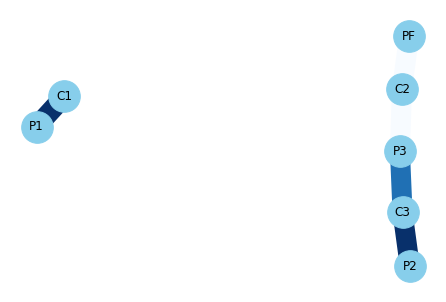

In [26]:
# Personalizar los nodosy dibujar el grafo
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1000, 
        edge_color=df['value'], width=20.0, edge_cmap=plt.cm.Blues)